In [2]:
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plot_params as pp

pp.fonts()

RE = "/wynton/group/ahituv/fongsl/projects/EMF/results/ATAC/WTC11NGN2.1"

DESEQ2 = os.path.join(RE,"deseq2_notDB.csv")
DESEQ2_ANNO= os.path.join(RE, "deseq2_notDB_peakAnno.csv")
RNAseq = "/wynton/group/ahituv/fongsl/projects/EMF/data/RNA/deseq2_Partek_PEMF_WTC11-NGN2_SF.txt" # fold change. N=14K
#RNAseq = "/wynton/group/ahituv/fongsl/projects/EMF/data/RNA/Normalized_counts_Partek_PEMF_WTC11-NGN2_SF.txt" # no fold change, only replicate info

In [46]:
df= pd.read_csv(DESEQ2)
dfan= pd.read_csv(DESEQ2_ANNO)
rna=pd.read_csv(RNAseq, sep='\t')
rna.head()

,Gene ID,Gene name,Chromosome,Start,Stop,Length,Strand,Total counts,Maximum counts,Geometric mean,...,Gene version,P-value (PEMF 60' vs control),FDR step up (PEMF 60' vs control),Ratio (PEMF 60' vs control),Log2(Ratio) (PEMF 60' vs control),Fold change (PEMF 60' vs control),LSMean(PEMF 60') (PEMF 60' vs control),LSMean(control) (PEMF 60' vs control),FC 95% lower limit (PEMF 60' vs control),FC 95% upper limit (PEMF 60' vs control)
0,7SK,7SK,6,52995620,52995951,331,+,17.946111,3.469604,2.161787,...,1,0.618931,?,0.739964,-0.434472,-1.351416,1.904660,2.573989,-4.427853,2.424459
1,A1BG,A1BG,19,58345178,58353493,8315,-,82.038151,11.502996,10.216092,...,12,0.990481,?,1.003385,0.004875,1.003385,10.271488,10.236841,-1.736226,1.747999
2,A1BG-AS1,A1BG-AS1,19,58347718,58355456,7738,+,30.653031,4.365862,3.813885,...,6,0.795317,?,1.126392,0.171709,1.126392,4.060407,3.604791,-2.181967,2.768389
3,A2M,A2M,12,9067664,9116230,48566,-,11.724931,1.988227,1.434478,...,15,0.870728,?,0.886729,-0.173435,-1.127741,1.376980,1.552876,-4.797590,3.772287
4,A2M-AS1,A2M-AS1,12,9065163,9068690,3527,+,40.740295,7.430818,4.983886,...,4,0.518548,?,1.297324,0.375538,1.297324,5.754614,4.435758,-1.698883,2.859303


## merge RNA and ATAC

In [48]:
# merge rna and atac
dfan = pd.merge(df, dfan[["seqnames", "start", "end", "SYMBOL", "distanceToTSS"]]) # merge the symbol into fold-change atac diffbind

df = pd.merge(dfan, rna, left_on="SYMBOL", right_on= "Gene ID")  # merge gene expression information

df[" Fold change (PEMF 60' vs control) "] = df["Fold change (PEMF 60' vs control)"].astype(float)

## annotate sig atac elements

In [49]:
sigcol_rna = "FDR step up (PEMF 60' vs control)"
sigcol_atac = "FDR"

RNA_FOLD="Fold change (PEMF 60' vs control)"
ATAC_FOLD="Fold"

alpha=0.05
df["sig_ATAC"], df["sig_RNA"] = False, False
df.loc[(df[sigcol_atac]!="?")&(df[sigcol_atac].astype(float)<=alpha), "sig_ATAC"]=True

df.loc[df[sigcol_rna]=="?", sigcol_rna] = -1  # replace all ? with -1

df[sigcol_rna]=df[sigcol_rna].astype(float)  # turn column into a float
df.loc[(df[sigcol_rna].astype(float)<=alpha), "sig_RNA"]=True # annotate RNA deseq2 FDR sign

In [50]:
data=df[["SYMBOL", RNA_FOLD, "sig_RNA"]].drop_duplicates()
data.head()

,SYMBOL,Fold change (PEMF 60' vs control),sig_RNA
0,CLUAP1,-1.086824,True
3,RAD50,1.158028,True
7,RSF1,1.199102,False
13,AQR,1.153784,True
16,DNAJC18,1.053670,True


<Axes: xlabel="Fold change (PEMF 60' vs control)", ylabel='Density'>

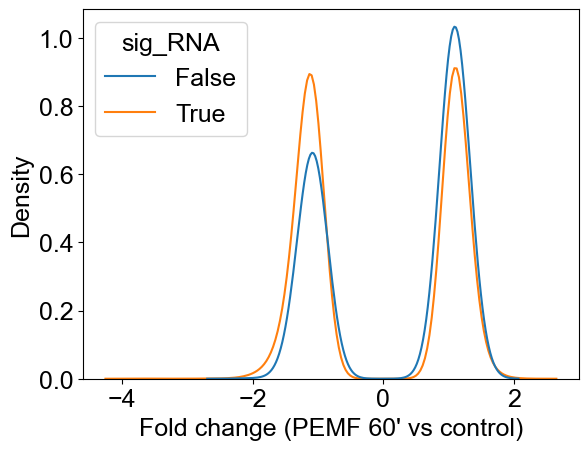

In [51]:
sns.kdeplot(x=RNA_FOLD, data=data, hue="sig_RNA", common_norm=False )

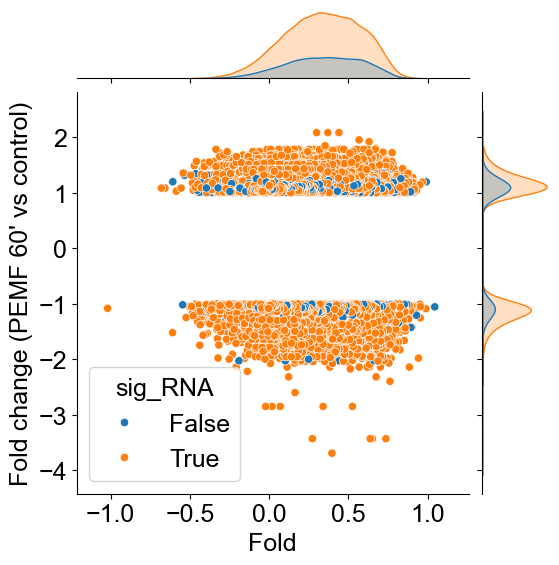

In [52]:
sns.jointplot(x=ATAC_FOLD, y=RNA_FOLD, data=df, hue="sig_RNA")

## ATAC-sig x RNA-sig elements

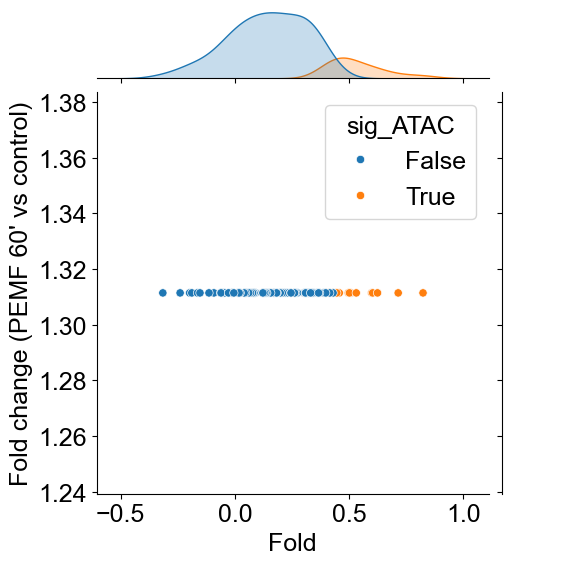

In [43]:
sns.jointplot(x="Fold", y="Fold change (PEMF 60' vs control)", data=df.loc[df["SYMBOL"]=="ROBO1"], hue='sig_ATAC')

# promoters fold change in accessibility ~ change in expression? 

(6767, 40)


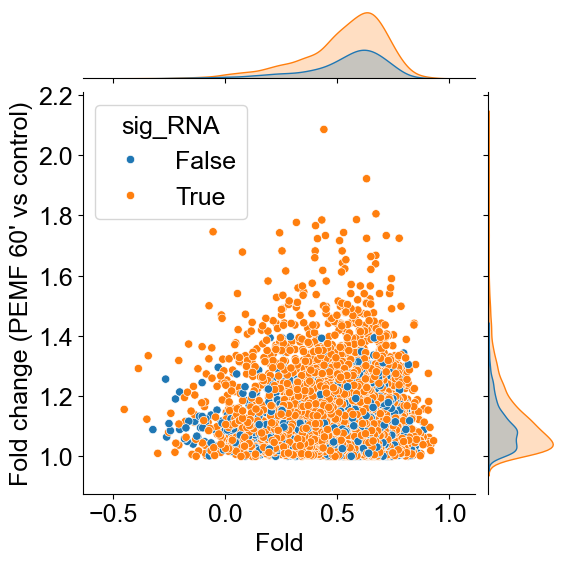

In [89]:
PROM_DIST=500
prom = df.loc[(df["distanceToTSS"].abs()<PROM_DIST) &(df[RNA_FOLD]>0)].copy().drop_duplicates()
print(prom.shape)

sns.jointplot(x=ATAC_FOLD, y=RNA_FOLD, data=prom, hue="sig_RNA")

#### significant RNA genes have slightly less promoter diffAcc than non sig.

<Axes: xlabel='Fold', ylabel='Count'>

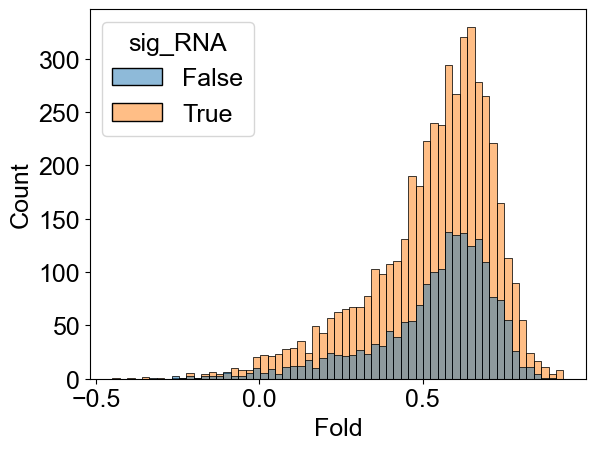

In [90]:
sns.histplot(x=ATAC_FOLD,data=prom, hue="sig_RNA")

In [91]:
stats.mannwhitneyu(prom.loc[prom["sig_RNA"]==True, ATAC_FOLD], prom.loc[prom["sig_RNA"]!=True, ATAC_FOLD], 
                  )

MannwhitneyuResult(statistic=4612779.0, pvalue=0.4029041358481531)

In [92]:
prom.groupby(["sig_RNA"])[ATAC_FOLD].median()  # significant RNA genes have slightly less promoter diffAcc than non sig.

sig_RNA
False    0.579733
True     0.571581
Name: Fold, dtype: float64